In [1]:
import tempfile

from diffpy.structure import Atom, Lattice, Structure
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.tri as tri

# Colorisation and visualisation
from matplotlib.colors import to_rgb
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D

In [2]:
def load_and_process_data(filepath):
    # Load the data from the file
    data = np.loadtxt(filepath, delimiter='\t', skiprows=1)
    #, max_rows=200000
    # Extract the x, y, z coordinates and the R values
    phase, x, y, z, R_flat = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 7:16]
    # Reshape R_flat into a list of 3x3 matrices
    R_list = [row.reshape(3, 3) for row in R_flat]
    # Stack the 3x3 matrices vertically
    R = np.vstack([r[np.newaxis, :, :] for r in R_list])
    # Calculate the 2-norm of each column for each 3x3 matrix
    norms = np.linalg.norm(R, axis=1, keepdims=True)
    # Normalize each 3x3 matrix by its column norms
    R_normalized = R / norms
    #print(np.shape(R_normalized))
    return phase, x, y, z, R_normalized

In [3]:
def get_ipf_color(vectors):
    vectors = np.abs(vectors)
    # Convert Cartesian coordinates to spherical coordinates
    h = vectors[:, 0]
    k = vectors[:, 1]
    l = vectors[:, 2]
    r = np.ones(len(vectors))
    theta = np.arcsin(np.dot(vectors, [1,0,0]))
    phi = np.arctan(l/k)
    phi = 0.5 * phi
    k_p = r * np.sin(theta) * np.cos(phi)
    l_p = r * np.sin(theta) * np.sin(phi)
    h_p = np.sqrt(r**2 - k_p**2 - l_p**2)
    gamma = np.arctan(h_p/k_p)
    gamma = 0.5 * gamma
    k_pp = np.sqrt((1-l**2)/(1+np.tan(gamma)**2))
    h_pp = np.tan(gamma) * k_pp
    l_pp = np.sqrt(r**2 - h_pp**2 - k_pp**2)
    hkl = np.stack((h_pp, k_pp, l_pp), axis=-1)
    cube_rgb = hkl / np.max(hkl, axis=1)[:, np.newaxis]
    
    return cube_rgb

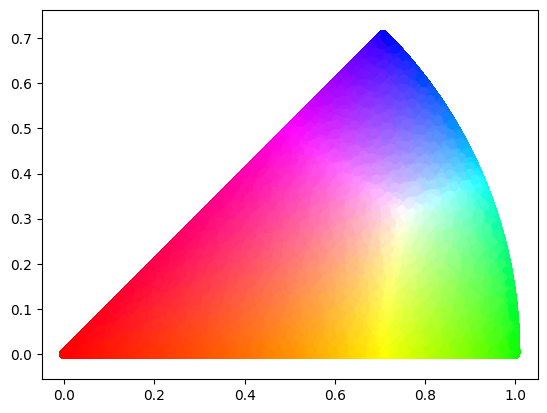

In [9]:
scale = 10000000
r = np.ones(scale)
theta = np.random.uniform(0, 0.5 * np.pi, scale)
phi = np.random.uniform(0, 0.5 * np.pi, scale)
# Convert back to Cartesian coordinates
h = r * np.cos(theta)
k = r * np.sin(theta) * np.cos(phi)
l = r * np.sin(theta) * np.sin(phi)
# Combine the coordinates into a new array
hkl = np.stack((h, k, l), axis=-1)
rgb = hkl / np.max(hkl, axis=1)[:, np.newaxis]
# print(hkl)
# print(rgb)
phi = 0.5 * phi
x = r * np.sin(theta) * np.cos(phi).flatten()
y = r * np.sin(theta) * np.sin(phi).flatten()
h_p = r * np.cos(theta)
k_p = r * np.sin(theta) * np.cos(phi)
gamma = np.arctan(h_p/k_p)
gamma = 0.5 * gamma
k_pp = np.sqrt((1-l**2)/(1+np.tan(gamma)**2))
h_pp = np.tan(gamma) * k_pp
plt.scatter(x, y, color=rgb)
plt.axis('equal')
plt.show()

In [5]:
# Generate and normalize coordinates
n = 1000000
coords = np.random.rand(n, 3)
coords /= np.max(coords, axis=0)

# Swap the x and y coordinates
coords[:, [0, 1]] = coords[:, [1, 0]]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*coords.T, c=coords)

# Invert the y-axis
ax.invert_yaxis()

# Set the labels
for ax, label in zip([ax.set_xlabel, ax.set_ylabel, ax.set_zlabel], ['R', 'G', 'B']): ax(label)

In [6]:
def plot_3d_ipf(phase, x, y, z, R_normalized):
    directions = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    titles = ["X", "Y", "Z"]
    mask = phase != 0
    x = x[mask]
    y = y[mask]
    z = z[mask]
    R_normalized = R_normalized[mask]
    
    fig = plt.figure(figsize=(10, 30))
    axes = [fig.add_subplot(3, 1, i+1, projection='3d') for i in range(3)]
    
    for i, ax in enumerate(axes):
        ax.set_title(f"IPF-{titles[i]}")
        vectors = R_normalized[:, :, i]
        cube_rgb = get_ipf_color(vectors)
        ax.scatter(x, y, z, c=cube_rgb, alpha=1, s=1)
        axis_limit = min(max(np.max([x, y, z]), 20), 20)
        ax.set_xlim(0, axis_limit)
        ax.set_ylim(0, axis_limit)
        ax.set_zlim(0, axis_limit)

    # Save the figure
    plt.savefig('3d_ipf_plot.png', dpi=600, bbox_inches='tight')
    plt.show()

In [7]:
def main():
    # Specify the filepath to the data file
    filepath = '3d_ebsd_20240619_R_appended_data.txt'
    # Load and process the data
    phase, x, y, z, R_normalized = load_and_process_data(filepath)
    # Plot the processed data
    plot_3d_ipf(phase, x, y, z, R_normalized)
    # color_bar()

/var/folders/ww/5vsdwswx1t510sdhmkz3673r0000gn/T/ipykernel_17558/2937717718.py:14: RuntimeWarning: invalid value encountered in divide
  R_normalized = R / norms


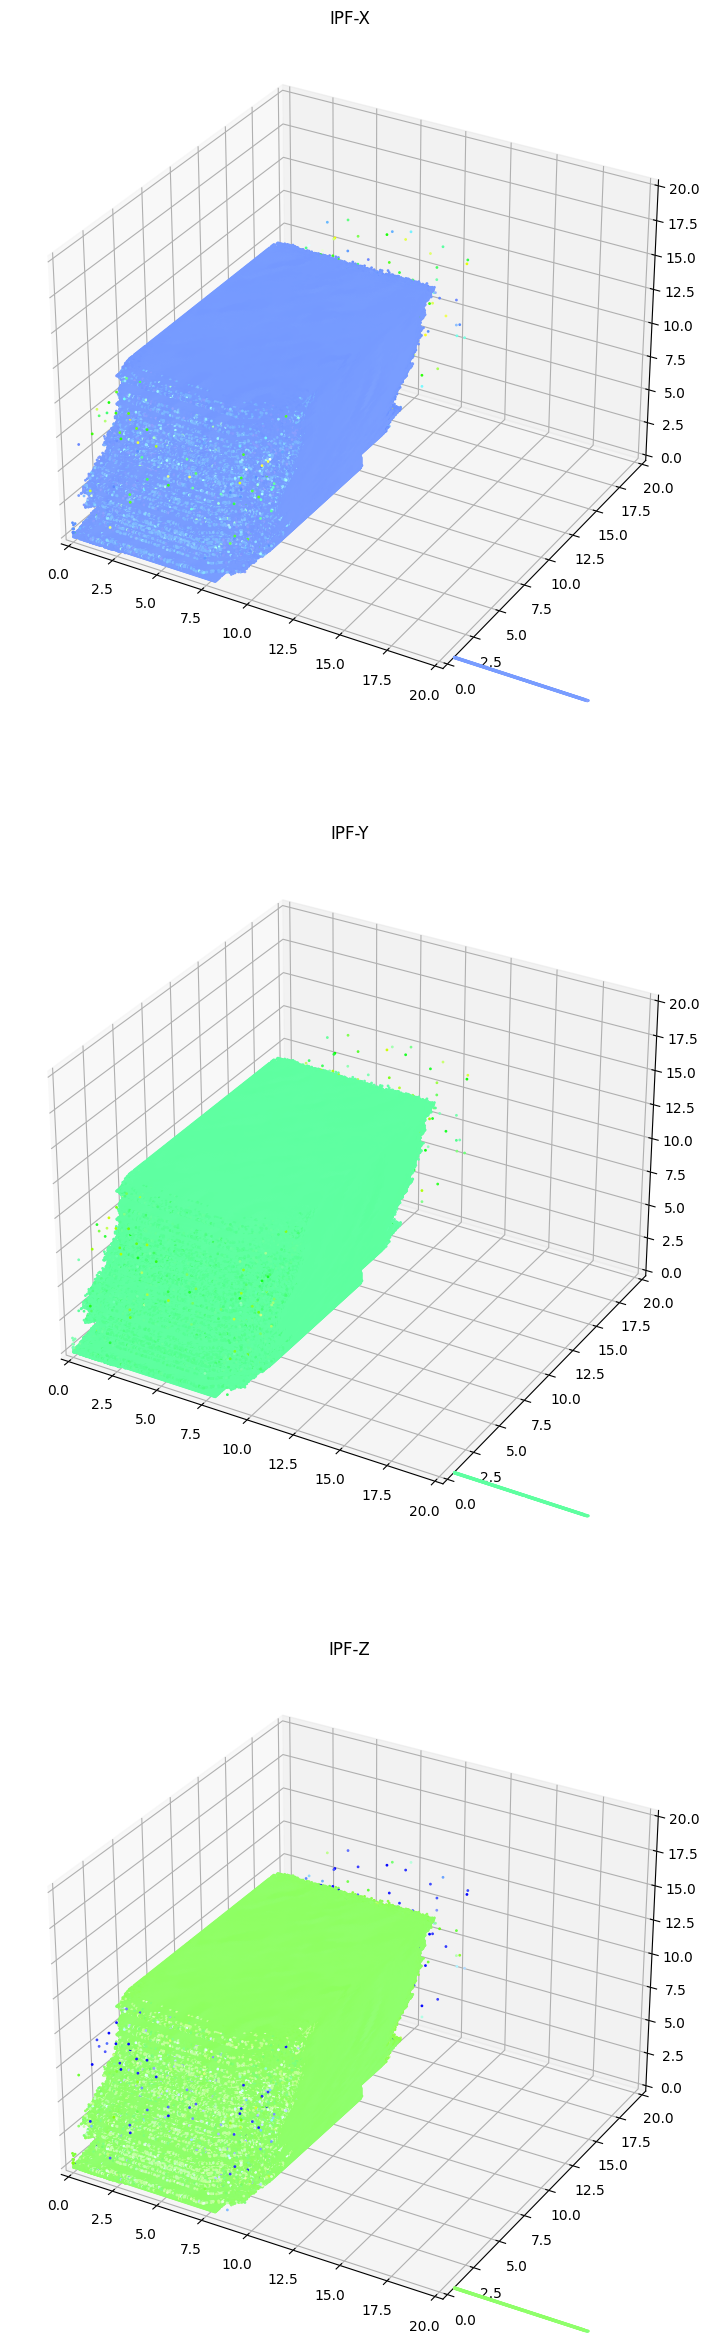

In [8]:
if __name__ == "__main__":
    main()